In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Setup

In [2]:
import numpy as np
import cv2
import tensorflow as tf
import os
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.applications import MobileNetV2
print(os.getcwd())

/content


In [3]:
#paths
csv_path = 'drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/seen.csv'
seen_folder_path = 'drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/plantvillagesmall/seen'
unseen_folder_path = 'drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/plantvillagesmall/unseen/Potato___healthy'
image_generator = 'drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/Models/image_gen.hdf5'

In [4]:
folders = os.listdir(seen_folder_path)
print(folders)

df = pd.read_csv(csv_path, header = None)
print(df)

['Peach___healthy', 'Tomato___Bacterial_spot', 'Tomato___healthy', 'Peach___Bacterial_spot', 'Tomato___Early_blight', 'Potato___Early_blight']
                         0  1  2  3
0  Tomato___Bacterial_spot  0  0  0
1   Peach___Bacterial_spot  1  0  1
2          Peach___healthy  1  1  2
3         Tomato___healthy  0  1  3
4    Potato___Early_blight  2  2  4
5    Tomato___Early_blight  0  2  5


In [5]:
# make dataset
unseen_dataset = []
plant_dataset_real = []
disease_dataset_real = []
plant_labels = {}
disease_labels = {}
combined_label_dict = {}

##Data loader

###Seen dataset

In [6]:
for index,row in df.iterrows():
  curr_folder_path = seen_folder_path + "/" + str(row[0])
  images = os.listdir(curr_folder_path)
  plant_labels[row[1]] = (str(row[0]).split("___"))[0]
  disease_labels[row[2]] = (str(row[0]).split("___"))[1]
  combined_label_dict[row[3]] = str(row[0])
  for i in tqdm(range(0,200)):
      select = random.choice(images)
      image = cv2.imread(os.path.join(curr_folder_path, select))
      image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image2 = tf.image.resize(image2, (128, 128))
      plant_dataset_real.append((image2, row[1]))
      disease_dataset_real.append((image2, row[2]))
      images.remove(select)

100%|██████████| 200/200 [00:02<00:00, 87.79it/s] 


In [7]:
print("Real plant image dataset\n===============================")
print(plant_labels)
print(len(plant_dataset_real))

print("\nReal disease image dataset\n===============================")
print(disease_labels)
print(len(disease_dataset_real))

print("\nCombined labels:")
print(combined_label_dict)

Real plant image dataset
{0: 'Tomato', 1: 'Peach', 2: 'Potato'}
1200

Real disease image dataset
{0: 'Bacterial_spot', 1: 'healthy', 2: 'Early_blight'}
1200

Combined labels:
{0: 'Tomato___Bacterial_spot', 1: 'Peach___Bacterial_spot', 2: 'Peach___healthy', 3: 'Tomato___healthy', 4: 'Potato___Early_blight', 5: 'Tomato___Early_blight'}


###Unseen dataset

In [8]:
curr_folder_path = unseen_folder_path
print(curr_folder_path)
images = os.listdir(curr_folder_path)
for i in tqdm(images):
    image = cv2.imread(os.path.join(curr_folder_path, i))
    image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    unseen_dataset.append(image2)


drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/plantvillagesmall/unseen/Potato___healthy


100%|██████████| 152/152 [00:00<00:00, 194.77it/s]


###Real + Fake dataset

####Image Generator architecture

In [9]:
from tensorflow.keras import layers
latent_dim = 100
classes = 6
def define_generator():
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,))

    label_embedding = layers.Flatten()(layers.Embedding(classes, latent_dim)(label))
    model_input = layers.Concatenate()([noise, label_embedding])

    x = layers.Dense(512 * 4 * 4)(model_input)

    x = layers.Reshape((4, 4, 512))(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.1)(x)

    x = layers.Conv2DTranspose(64 * 8, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(), name='conv_transpose_1')(x)
    x = layers.BatchNormalization(momentum=0.1, name='bn_1')(x)
    x = layers.LeakyReLU(name='leaky_relu_1')(x)

    x = layers.Conv2DTranspose(64 * 4, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(), name='conv_transpose_2')(x)
    x = layers.BatchNormalization(momentum=0.1, name='bn_2')(x)
    x = layers.LeakyReLU(name='leaky_relu_2')(x)

    x = layers.Conv2DTranspose(64 * 2, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(), name='conv_transpose_3')(x)
    x = layers.BatchNormalization(momentum=0.1, name='bn_3')(x)
    x = layers.LeakyReLU(name='leaky_relu_3')(x)

    x = layers.Conv2DTranspose(64 * 1, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(), name='conv_transpose_4')(x)
    x = layers.BatchNormalization(momentum=0.1, name='bn_4')(x)
    x = layers.LeakyReLU(name='leaky_relu_4')(x)

    out_layer = layers.Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(),  activation='tanh', name='conv_transpose_6')(x)

   # define model
    model = tf.keras.Model([noise, label], out_layer)
    return model

image_gen = define_generator()
image_gen.load_weights(image_generator)
print(image_gen.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       600         ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 100)          0           ['embedding[0][0]']              
                                                                                              

####Generate fake images

In [10]:
fake_dataset = []
seed = tf.random.normal([100, latent_dim])
seed.dtype
for i in range(6):
   curr_label = []
   for j in range(100):
        curr_label.append(i)
   curr_label = tf.convert_to_tensor(curr_label)
   images = image_gen([seed, curr_label], training=False)
   for k in range(images.shape[0]):
      pred = (images[i, :, :, :] + 1 ) * 127.5
      pred = np.array(pred)
      fake_dataset.append((pred, i))

print(len(fake_dataset))

600


In [11]:
plant_dataset_fake = []
disease_dataset_fake = []
import matplotlib.pyplot as plt

for img, lab in fake_dataset:
  label = combined_label_dict[lab]
  plant = (label.split("___"))[0]
  disease = (label.split("___"))[1]
  image = img.astype(np.uint8)
  plant_dataset_fake.append((image, list(plant_labels.values()).index(plant)))
  disease_dataset_fake.append((image, list(disease_labels.values()).index(disease)))

print(len(plant_dataset_fake))
print(len(disease_dataset_fake))

real_fake_plant_dataset = np.concatenate((plant_dataset_real, plant_dataset_fake), axis=0)
real_fake_disease_dataset = np.concatenate((disease_dataset_real, disease_dataset_fake), axis=0)

print(len(real_fake_plant_dataset))
print(len(real_fake_disease_dataset))
print(np.array(real_fake_plant_dataset).shape)
print(np.array(real_fake_disease_dataset).shape)

600
600
1800
1800
(1800, 2)
(1800, 2)


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#Real image classifier

##Architecture

In [12]:
image_input = tf.keras.layers.Input(shape=(128,128,3))

mobilenet = MobileNetV2(include_top=False, input_tensor=image_input)
mobilenet.trainable = True

plant_image_real = tf.keras.Sequential([
  tf.keras.layers.Input(shape = (128,128,3)),
  mobilenet,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(3,activation='softmax')
])

disease_image_real = tf.keras.Sequential([
  tf.keras.layers.Input(shape = (128,128,3)),
  mobilenet,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(3,activation='softmax')
])

##Plant classifier

In [13]:
np.random.shuffle(plant_dataset_real)

train, test = train_test_split(plant_dataset_real, test_size = 0.4)

train_images = np.array([item[0] for item in train])
train_labels = np.array([item[1] for item in train])

test_images = np.array([item[0] for item in test])
test_labels = np.array([item[1] for item in test])

print("Train length: ", str(len(train_images)))
print("Test length: ", str(len(test_images)))

train_images = tf.image.resize(train_images, (128, 128))
train_labels = tf.one_hot(train_labels, depth=3)

test_images = tf.image.resize(test_images, (128, 128))
test_labels = tf.one_hot(test_labels, depth=3)

print(train_images.shape)
print(test_images.shape)

Train length:  720
Test length:  480
(720, 128, 128, 3)
(480, 128, 128, 3)


In [14]:
plant_image_real.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
plant_image_real.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               10486272  
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 12,745,795
Trainable params: 12,711,683
Non-trainable params: 34,112
_________________________________________________________________


In [15]:
# train the model
history = model_fit = plant_image_real.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# evaluate model
_, train_acc = plant_image_real.evaluate(train_images, train_labels)
_, test_acc = plant_image_real.evaluate(test_images, test_labels )

print(f'\nTrain accuracy: {train_acc:.0%}')
print(f'Test accuracy: {test_acc:.0%}')

plant_image_real.save('drive/MyDrive/Colab Notebooks/IIIP/Testing chamber/Models/plant_image_real_classifier.hdf5')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 [==============================] - 37s 165ms/step - loss: 0.4445 - accuracy: 0.8569 - val_loss: 4.1196 - val_accuracy: 0.5208
Epoch 2/10
23/23 [==============================] - 2s 68ms/step - loss: 0.0058 - accuracy: 0.9986 - val_loss: 4.7503 - val_accuracy: 0.5688
Epoch 3/10
23/23 [==============================] - 2s 72ms/step - loss: 0.0125 - accuracy: 0.9972 - val_loss: 5.1204 - val_accuracy: 0.5542
Epoch 4/10
23/23 [==============================] - 2s 73ms/step - loss: 0.0184 - accuracy: 0.9931 - val_loss: 2.9675 - val_accuracy: 0.6979
Epoch 5/10
23/23 [==============================] - 2s 67ms/step - loss: 0.0111 - accuracy: 0.9958 - val_loss: 2.3539 - val_accuracy: 0.7312
Epoch 6/10
23/23 [==============================] - 1s 66ms/step - loss: 0.0205 - accuracy: 0.9903 - val_loss: 2.2029 - val_accuracy: 0.7437
Epoch 7/10
23/23 [==============================] - 1s 65ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 1.9096 - val_accuracy: 0.7458
Epoch 8/10
23/23 [====

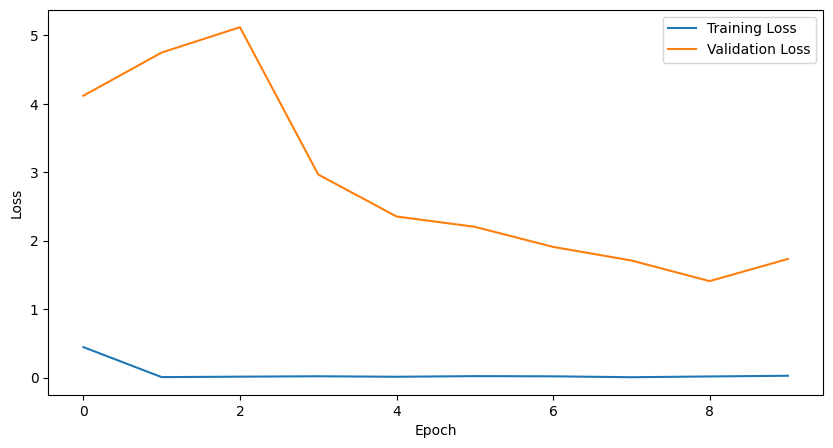

In [16]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

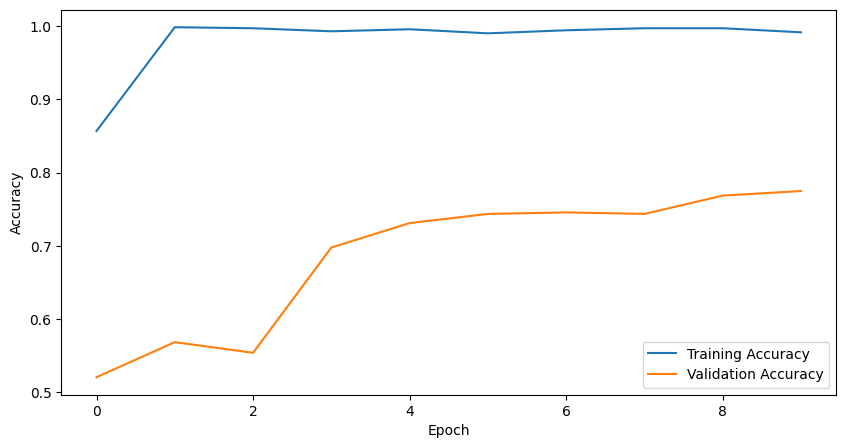

In [17]:
# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Disease classifier

In [18]:
np.random.shuffle(disease_dataset_real)

train, test = train_test_split(disease_dataset_real, test_size = 0.4)

train_images = np.array([item[0] for item in train])
train_labels = np.array([item[1] for item in train])

test_images = np.array([item[0] for item in test])
test_labels = np.array([item[1] for item in test])

print("Train length: ", str(len(train_images)))
print("Test length: ", str(len(test_images)))

train_images = tf.image.resize(train_images, (128, 128))
train_labels = tf.one_hot(train_labels, depth=3)

test_images = tf.image.resize(test_images, (128, 128))
test_labels = tf.one_hot(test_labels, depth=3)

print(train_images.shape)
print(test_images.shape)

Train length:  720
Test length:  480
(720, 128, 128, 3)
(480, 128, 128, 3)


In [19]:
disease_image_real.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
disease_image_real.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               10486272  
                                                                 
 dense_4 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 12,745,795
Trainable params: 12,711,683
Non-trainable params: 34,112
_________________________________________________________________


In [20]:
# train the model
history = model_fit = disease_image_real.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# evaluate model
_, train_acc = disease_image_real.evaluate(train_images, train_labels)
_, test_acc = disease_image_real.evaluate(test_images, test_labels )

print(f'\nTrain accuracy: {train_acc:.0%}')
print(f'Test accuracy: {test_acc:.0%}')

disease_image_real.save('drive/MyDrive/Colab Notebooks/IIIP/Testing chamber/Models/disease_image_real_classifier.hdf5')


Epoch 1/10
23/23 [==============================] - 34s 197ms/step - loss: 0.5905 - accuracy: 0.8042 - val_loss: 1.8201 - val_accuracy: 0.6167
Epoch 2/10
23/23 [==============================] - 2s 71ms/step - loss: 0.0546 - accuracy: 0.9833 - val_loss: 1.6098 - val_accuracy: 0.7042
Epoch 3/10
23/23 [==============================] - 2s 72ms/step - loss: 0.0337 - accuracy: 0.9861 - val_loss: 2.7288 - val_accuracy: 0.6667
Epoch 4/10
23/23 [==============================] - 1s 65ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 1.6474 - val_accuracy: 0.7083
Epoch 5/10
23/23 [==============================] - 2s 68ms/step - loss: 0.0199 - accuracy: 0.9972 - val_loss: 1.2571 - val_accuracy: 0.7604
Epoch 6/10
23/23 [==============================] - 1s 66ms/step - loss: 0.0128 - accuracy: 0.9944 - val_loss: 2.2795 - val_accuracy: 0.7104
Epoch 7/10
23/23 [==============================] - 2s 69ms/step - loss: 0.0076 - accuracy: 0.9972 - val_loss: 1.5760 - val_accuracy: 0.7521
Epoch 8/10


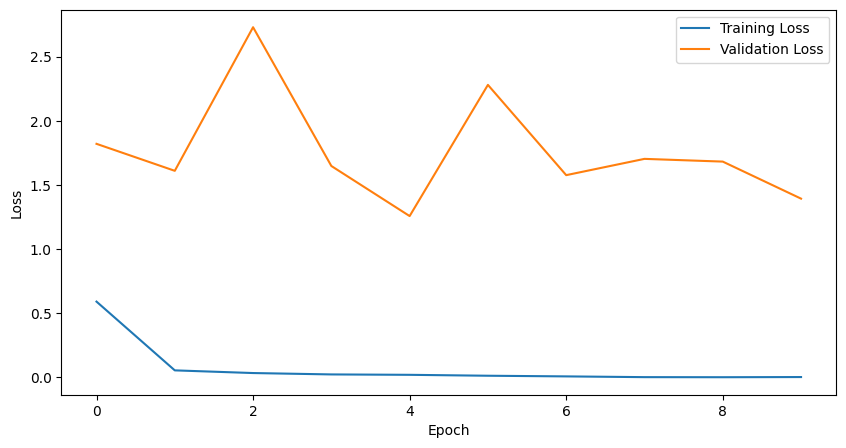

In [21]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

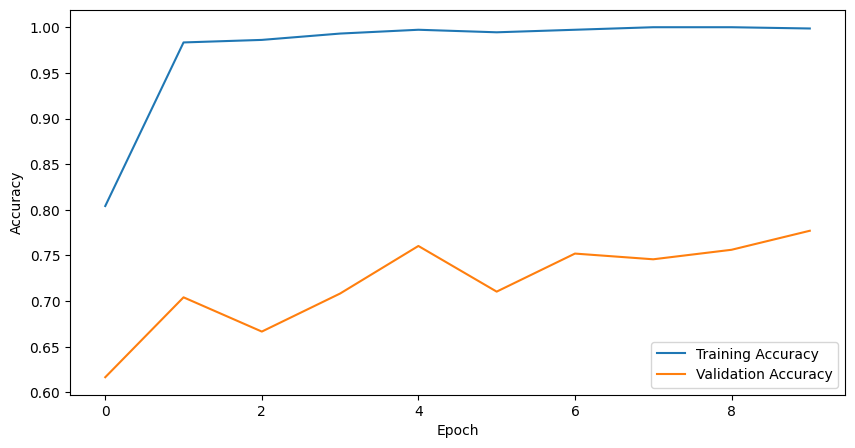

In [22]:
# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Real + Fake image classifier

##Architecture

In [23]:
image_input = tf.keras.layers.Input(shape=(128,128,3))

mobilenet = MobileNetV2(include_top=False, input_tensor=image_input)
mobilenet.trainable = True

plant_image_real_fake = tf.keras.Sequential([
  tf.keras.layers.Input(shape = (128,128,3)),
  mobilenet,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(3,activation='softmax')
])

disease_image_real_fake = tf.keras.Sequential([
  tf.keras.layers.Input(shape = (128,128,3)),
  mobilenet,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(3,activation='softmax')
])

##Plant classifier

In [24]:
np.random.shuffle(real_fake_plant_dataset)

train, test = train_test_split(real_fake_plant_dataset, test_size = 0.4)

train_images = np.array([item[0] for item in train])
train_labels = np.array([item[1] for item in train])

test_images = np.array([item[0] for item in test])
test_labels = np.array([item[1] for item in test])

print("Train length: ", str(len(train_images)))
print("Test length: ", str(len(test_images)))

train_images = tf.image.resize(train_images, (128, 128))
train_labels = tf.one_hot(train_labels, depth=3)

test_images = tf.image.resize(test_images, (128, 128))
test_labels = tf.one_hot(test_labels, depth=3)

print(train_images.shape)
print(test_images.shape)

Train length:  1080
Test length:  720
(1080, 128, 128, 3)
(720, 128, 128, 3)


In [25]:
plant_image_real_fake.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
plant_image_real_fake.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 20480)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               10486272  
                                                                 
 dense_6 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 12,745,795
Trainable params: 12,711,683
Non-trainable params: 34,112
_________________________________________________________________


In [26]:
# train the model
history = model_fit = plant_image_real_fake.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# evaluate model
_, train_acc = plant_image_real_fake.evaluate(train_images, train_labels)
_, test_acc = plant_image_real_fake.evaluate(test_images, test_labels )

print(f'\nTrain accuracy: {train_acc:.0%}')
print(f'Test accuracy: {test_acc:.0%}')

plant_image_real_fake.save('drive/MyDrive/Colab Notebooks/IIIP/Testing chamber/Models/plant_image_real_fake_classifier.hdf5')


Epoch 1/10
34/34 [==============================] - 37s 126ms/step - loss: 0.3095 - accuracy: 0.9009 - val_loss: 4.4972 - val_accuracy: 0.4792
Epoch 2/10
34/34 [==============================] - 2s 65ms/step - loss: 0.0329 - accuracy: 0.9880 - val_loss: 3.8785 - val_accuracy: 0.5806
Epoch 3/10
34/34 [==============================] - 2s 74ms/step - loss: 0.0152 - accuracy: 0.9935 - val_loss: 3.6010 - val_accuracy: 0.5819
Epoch 4/10
34/34 [==============================] - 2s 70ms/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 3.2177 - val_accuracy: 0.6125
Epoch 5/10
34/34 [==============================] - 2s 72ms/step - loss: 0.0070 - accuracy: 0.9963 - val_loss: 2.4034 - val_accuracy: 0.6278
Epoch 6/10
34/34 [==============================] - 3s 74ms/step - loss: 0.0049 - accuracy: 0.9981 - val_loss: 1.2584 - val_accuracy: 0.7542
Epoch 7/10
34/34 [==============================] - 2s 74ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7757 - val_accuracy: 0.8597
Epoch 8/10


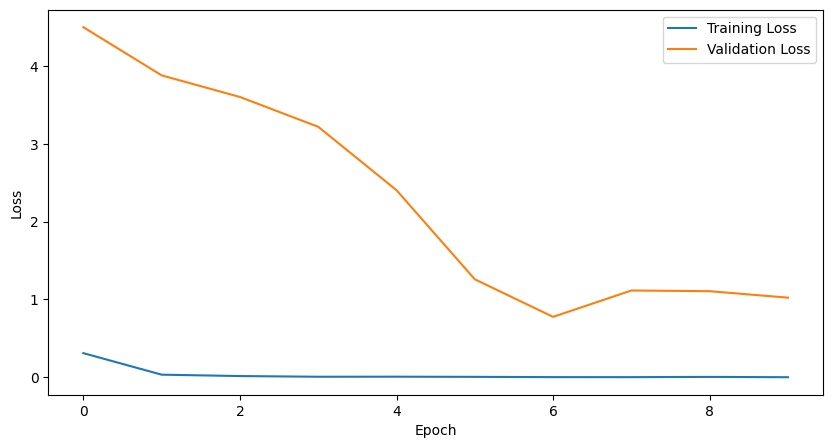

In [27]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

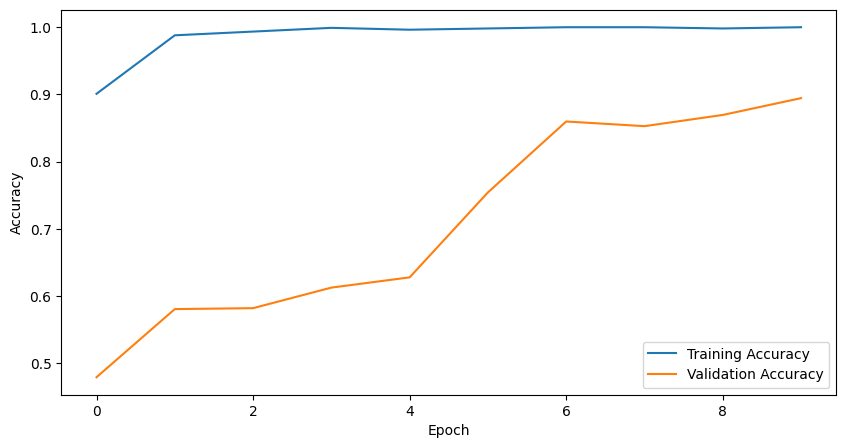

In [28]:
# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Disease classifier

In [29]:
np.random.shuffle(real_fake_disease_dataset)

train, test = train_test_split(real_fake_disease_dataset, test_size = 0.4)

train_images = np.array([item[0] for item in train])
train_labels = np.array([item[1] for item in train])

test_images = np.array([item[0] for item in test])
test_labels = np.array([item[1] for item in test])

print("Train length: ", str(len(train_images)))
print("Test length: ", str(len(test_images)))

train_images = tf.image.resize(train_images, (128, 128))
train_labels = tf.one_hot(train_labels, depth=3)

test_images = tf.image.resize(test_images, (128, 128))
test_labels = tf.one_hot(test_labels, depth=3)

print(train_images.shape)
print(test_images.shape)

Train length:  1080
Test length:  720
(1080, 128, 128, 3)
(720, 128, 128, 3)


In [30]:
disease_image_real_fake.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
disease_image_real_fake.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 20480)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               10486272  
                                                                 
 dense_8 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 12,745,795
Trainable params: 12,711,683
Non-trainable params: 34,112
_________________________________________________________________


In [31]:
# train the model
history = model_fit = disease_image_real_fake.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# evaluate model
_, train_acc = disease_image_real_fake.evaluate(train_images, train_labels)
_, test_acc = disease_image_real_fake.evaluate(test_images, test_labels )

print(f'\nTrain accuracy: {train_acc:.0%}')
print(f'Test accuracy: {test_acc:.0%}')

disease_image_real_fake.save('drive/MyDrive/Colab Notebooks/IIIP/Testing chamber/Models/disease_image_real_fake_classifier.hdf5')


Epoch 1/10
34/34 [==============================] - 33s 105ms/step - loss: 0.3306 - accuracy: 0.8843 - val_loss: 0.9288 - val_accuracy: 0.7875
Epoch 2/10
34/34 [==============================] - 3s 75ms/step - loss: 0.0235 - accuracy: 0.9935 - val_loss: 1.2614 - val_accuracy: 0.7694
Epoch 3/10
34/34 [==============================] - 2s 73ms/step - loss: 0.0224 - accuracy: 0.9944 - val_loss: 1.1685 - val_accuracy: 0.7403
Epoch 4/10
34/34 [==============================] - 2s 73ms/step - loss: 0.0064 - accuracy: 0.9991 - val_loss: 0.8431 - val_accuracy: 0.8250
Epoch 5/10
34/34 [==============================] - 3s 74ms/step - loss: 0.0117 - accuracy: 0.9954 - val_loss: 0.8999 - val_accuracy: 0.7806
Epoch 6/10
34/34 [==============================] - 2s 74ms/step - loss: 0.0138 - accuracy: 0.9944 - val_loss: 0.9907 - val_accuracy: 0.7792
Epoch 7/10
34/34 [==============================] - 2s 66ms/step - loss: 0.0694 - accuracy: 0.9806 - val_loss: 1.0559 - val_accuracy: 0.7417
Epoch 8/10


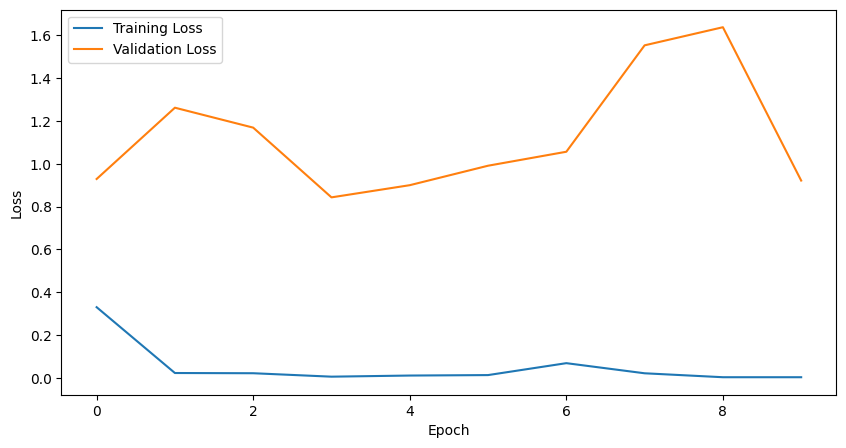

In [32]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

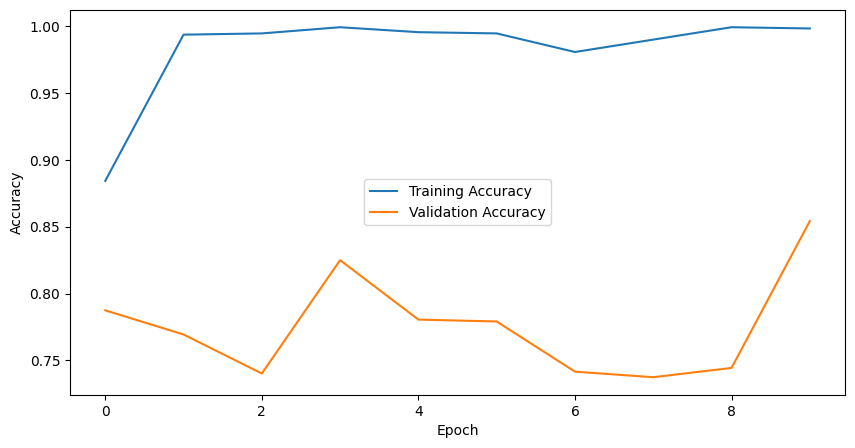

In [33]:
# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Testing on unseen

In [34]:
unseen_images = tf.image.resize(unseen_dataset, (128, 128))

In [35]:
plant_unseen_label = tf.one_hot(np.full(len(unseen_images), 2), depth=3)
disease_unseen_label = tf.one_hot(np.ones(len(unseen_images)), depth=3)

##Models trained on real dataset

In [36]:
loss, real_plant_acc = plant_image_real.evaluate(unseen_images,plant_unseen_label)
loss, real_disease_acc = disease_image_real.evaluate(unseen_images,disease_unseen_label)
print("True Label: Potato, accuracy: " + str(real_plant_acc*100))
print("True Label: Healthy, accuracy: " + str(real_disease_acc*100))

5/5 [==============================] - 0s 24ms/step - loss: 0.9668 - accuracy: 0.7632
True Label: Potato, accuracy: 14.473684132099152
True Label: Healthy, accuracy: 76.31579041481018


##Models trained on real+fake dataset

In [37]:
loss, real_fake_plant_acc = plant_image_real_fake.evaluate(unseen_images,plant_unseen_label)
loss, real_fake_disease_acc = disease_image_real_fake.evaluate(unseen_images,disease_unseen_label)
print("True Label: Potato, accuracy: " + str(real_fake_plant_acc*100))
print("True Label: Healthy, accuracy: " + str(real_fake_disease_acc*100))

5/5 [==============================] - 0s 25ms/step - loss: 0.2044 - accuracy: 0.9539
True Label: Potato, accuracy: 32.894736528396606
True Label: Healthy, accuracy: 95.3947365283966


In [38]:
print("Performance increase of plant classification: " + str(((real_fake_plant_acc - real_plant_acc)/real_plant_acc)*100))
print("Performance increase of disease classification: " + str(((real_fake_disease_acc - real_disease_acc)/real_disease_acc)*100))

Performance increase of plant classification: 127.27272633678656
Performance increase of disease classification: 24.999998047434076
